# Cell 1: Import Libraries

In [1]:


import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from deap import base, creator, tools, algorithms

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Enable inline plotting
%matplotlib inline


# Cell 2: Data Loading and Preprocessing

In [2]:


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
full_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Reduce dataset size to simulate limited data
small_dataset_size = 1000  # Use only 1000 samples
indices = list(range(len(full_dataset)))
random.shuffle(indices)
small_indices = indices[:small_dataset_size]

small_dataset = torch.utils.data.Subset(full_dataset, small_indices)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(small_dataset, batch_size=32, shuffle=True)


# Cell 3: Visualize Sample Data

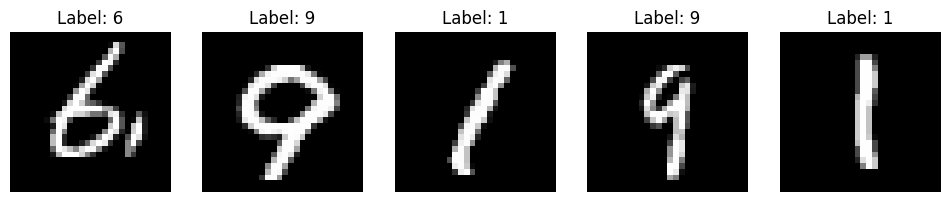

In [3]:


def show_images(dataset, indices):
    fig, axes = plt.subplots(1, len(indices), figsize=(12, 3))
    for ax, idx in zip(axes, indices):
        img, label = dataset[idx]
        img = img.numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

# Display first 5 images in the small dataset
sample_indices = small_indices[:5]
show_images(full_dataset, sample_indices)


# Cell 4: Define the Search Space and Evolutionary Algorithm Setup


In [4]:

# Possible values for network architecture
NUM_LAYERS = [1, 2, 3]
NUM_NEURONS = [32, 64, 128, 256]
ACTIVATION_FUNCTIONS = [nn.ReLU, nn.Tanh, nn.Sigmoid]
LEARNING_RATES = [0.01, 0.001, 0.0001]

# Define individual and fitness classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize accuracy
creator.create("Individual", list, fitness=creator.FitnessMax)

# Function to create an individual
def create_individual():
    num_layers = random.choice(NUM_LAYERS)
    neurons = [random.choice(NUM_NEURONS) for _ in range(num_layers)]
    activation = random.choice(ACTIVATION_FUNCTIONS)
    learning_rate = random.choice(LEARNING_RATES)
    return creator.Individual([neurons, activation, learning_rate])

# Initialize the toolbox
toolbox = base.Toolbox()
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# Cell 5: Define the Evaluation Function

In [5]:


def evaluate_individual(individual):
    neurons, activation_fn, learning_rate = individual
    num_classes = 10  # MNIST has 10 classes

    # Define the neural network architecture
    class SimpleNet(nn.Module):
        def __init__(self):
            super(SimpleNet, self).__init__()
            layers = []
            input_size = 28 * 28
            for neuron_count in neurons:
                layers.append(nn.Linear(input_size, neuron_count))
                layers.append(activation_fn())
                input_size = neuron_count
            layers.append(nn.Linear(input_size, num_classes))
            self.net = nn.Sequential(*layers)

        def forward(self, x):
            x = x.view(-1, 28 * 28)
            return self.net(x)

    # Initialize the network
    model = SimpleNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    epochs = 1  # Keep epochs low for quick evaluation
    model.train()
    try:
        for epoch in range(epochs):
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
        # Evaluate accuracy on training data
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for data, target in train_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = correct / total
    except Exception as e:
        # If the model fails to train, assign a low fitness score
        accuracy = 0.0
    return (accuracy,)


# Cell 6: Define Genetic Operators

In [6]:


def mutate_individual(individual):
    # Mutate neurons
    if random.random() < 0.5:
        num_layers = random.choice(NUM_LAYERS)
        individual[0] = [random.choice(NUM_NEURONS) for _ in range(num_layers)]
    # Mutate activation function
    if random.random() < 0.5:
        individual[1] = random.choice(ACTIVATION_FUNCTIONS)
    # Mutate learning rate
    if random.random() < 0.5:
        individual[2] = random.choice(LEARNING_RATES)
    return individual,

def crossover_individuals(ind1, ind2):
    # Swap neurons
    if random.random() < 0.5:
        ind1[0], ind2[0] = ind2[0], ind1[0]
    # Swap activation function
    if random.random() < 0.5:
        ind1[1], ind2[1] = ind2[1], ind1[1]
    # Swap learning rate
    if random.random() < 0.5:
        ind1[2], ind2[2] = ind2[2], ind1[2]
    return ind1, ind2

# Register genetic operators
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", crossover_individuals)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)


# Cell 7: Run the Evolutionary Algorithm

In [7]:


def run_evolution():
    population_size = 20  # Start with a small population
    num_generations = 10   # Use fewer generations for quick testing
    population = toolbox.population(n=population_size)

    # Statistics to keep track of progress
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    # Evolutionary algorithm parameters
    cxpb = 0.5  # Crossover probability
    mutpb = 0.2  # Mutation probability

    # Run the evolutionary algorithm
    population, logbook = algorithms.eaSimple(population, toolbox,
                                              cxpb=cxpb, mutpb=mutpb,
                                              ngen=num_generations,
                                              stats=stats,
                                              verbose=True)
    return population, logbook

population, logbook = run_evolution()


gen	nevals	avg   	max  
0  	20    	0.4793	0.881
1  	15    	0.6538	0.886
2  	11    	0.76565	0.881
3  	12    	0.80955	0.892
4  	11    	0.8396 	0.897
5  	11    	0.84265	0.894
6  	11    	0.84595	0.894
7  	16    	0.84585	0.908
8  	14    	0.87535	0.908
9  	11    	0.87265	0.906
10 	6     	0.84875	0.906


# Cell 8: Analyze Results

Best Individual:
Neurons per Layer: [256]
Activation Function: Sigmoid
Learning Rate: 0.01
Fitness (Accuracy): 0.9060


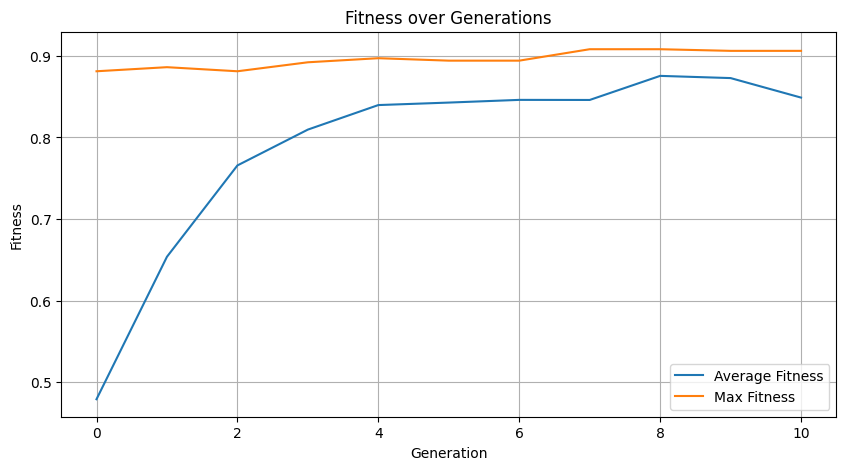

In [8]:


# Find the best individual
top_individual = tools.selBest(population, k=1)[0]
neurons, activation_fn, learning_rate = top_individual

print("Best Individual:")
print(f"Neurons per Layer: {neurons}")
print(f"Activation Function: {activation_fn.__name__}")
print(f"Learning Rate: {learning_rate}")
print(f"Fitness (Accuracy): {top_individual.fitness.values[0]:.4f}")

# Plot the evolution of fitness over generations
gen = logbook.select("gen")
avg_fitness = logbook.select("avg")
max_fitness = logbook.select("max")

plt.figure(figsize=(10, 5))
plt.plot(gen, avg_fitness, label='Average Fitness')
plt.plot(gen, max_fitness, label='Max Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness over Generations')
plt.legend()
plt.grid(True)
plt.show()


# Cell 9: Visualize the Best Model's Performance

In [9]:


# Re-train the best model to see its performance
best_neurons = neurons
best_activation_fn = activation_fn
best_learning_rate = learning_rate

class BestNet(nn.Module):
    def __init__(self):
        super(BestNet, self).__init__()
        layers = []
        input_size = 28 * 28
        for neuron_count in best_neurons:
            layers.append(nn.Linear(input_size, neuron_count))
            layers.append(best_activation_fn())
            input_size = neuron_count
        layers.append(nn.Linear(input_size, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.net(x)

# Initialize the network
best_model = BestNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)

# Training loop
epochs = 5  # Train for more epochs
best_model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = best_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

# Evaluate on training data
correct = 0
total = 0
best_model.eval()
with torch.no_grad():
    for data, target in train_loader:
        output = best_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
accuracy = correct / total
print(f'Training Accuracy: {accuracy:.4f}')


Epoch 1/5, Loss: 1.2378
Epoch 2/5, Loss: 0.3994
Epoch 3/5, Loss: 0.2511
Epoch 4/5, Loss: 0.1622
Epoch 5/5, Loss: 0.0962
Training Accuracy: 0.9880


# Cell 10: Test on Validation Data (Optional)

In [10]:


# Load test dataset
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate on test data
correct = 0
total = 0
best_model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = best_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.8888
